## Import the necessary libraries

In [1]:
# Python packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
# Wordcount visualizations
from wordcloud import WordCloud
# NLP
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from spacy import displacy
from bs4 import BeautifulSoup
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Optimization
from sklearn.model_selection import GridSearchCV
# Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score
# Warnings
import warnings


  
# **Import Data** 

In [2]:
train = pd.read_csv('../input/climate-change-edsa2020-21/train.csv')
test = pd.read_csv('../input/climate-change-edsa2020-21/test.csv')
sample = pd.read_csv('../input/climate-change-edsa2020-21/sample_submission.csv')
data = pd.read_csv('../input/mbti-type/mbti_1.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 'J':'Judging', 'P': 'Perceiving'}

FileNotFoundError: [Errno 2] No such file or directory: '../input/mbti-type/mbti_1.csv'

In [3]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [4]:
# view data
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
# Data summary and checking for nulls
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
# label the stance indicated by the class
labels_dict = {-1: 'Agnostic',0: 'Neutral',1: 'Believer',2: 'News'}
# Replace class values with tweet stance:
train.replace({'sentiment': labels_dict}, inplace=True)

In [7]:
# Document Corpus
raw_corpus = [statement.lower() for statement in train.message]

# **Exploratory Data Analysis**

The following section sets out to do analysis on the raw data and prime non essential elements for improved perfomance of the model(s).

# **Class WordCount** 

The aim is to calculate the frequency of words in each class and find the most used words for each class.

In [8]:
def word_count(df,Corpus):
    """Output graph of most frequent words in each class
       given a dataframe with a class column and a corpus """
    fig, axs = plt.subplots(2,2, figsize=(16,8),)
    fig.subplots_adjust(hspace = 0.5, wspace=.2)
    axs = axs.ravel()
    for index, stance in enumerate(df.sentiment.unique()):
        corpus = np.array(Corpus)[df[df.sentiment == stance].index.values]
        corpus = ' '.join(corpus).split(' ')
        word_counts = {}
        for word in corpus:
            if word in word_counts.keys():
                word_counts[word] += 1
            else:
                word_counts[word] = 1
        word_val_pair = []
        for word,word_freq in word_counts.items():
            word_val_pair.append((word,word_freq))
        word_val_pair.sort(key = lambda x: x[1],reverse=True)
        words = []
        frequency = []
        for word_val in word_val_pair[:10]:
            words.append(word_val[0])
            frequency.append(word_val[1])
        axs[index].set_title(f'{stance}',fontsize=15)
        axs[index].bar(x=words,height=frequency,edgecolor='k')
    

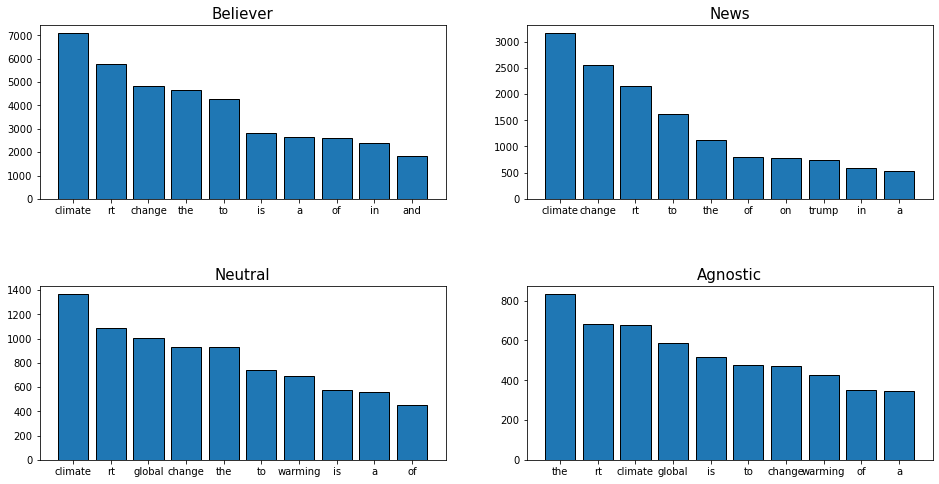

In [9]:
word_count(train,raw_corpus)

The plots between classes show the 10 most used words in each class, it can be seen that climate is the most used word in the data sets in 3 of the four clases, the plots also consist of common english words which offer little insights, futher cleaning must be done to remove these words.

In [10]:
# Word Cloud
def word_cloud(input_df,Corpus):
    """Function output the wordcloud of a class given
       a dataframe with a sentiment column and a corpus"""
    df = input_df.copy()
    fig, axs = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(hspace = 0.5, wspace=.2)
    axs = axs.ravel()
    for index, stance in enumerate(df.sentiment.unique()):
        corpus = np.array(Corpus)[df[df.sentiment == stance].index.values]
        corpus = ' '.join(corpus)
        word_cloud = WordCloud(background_color='white', max_font_size=80).generate(corpus)
        axs[index].set_title(f'{stance}',fontsize=15)
        axs[index].imshow(word_cloud,interpolation='bilinear')
        axs[index].axis('off')

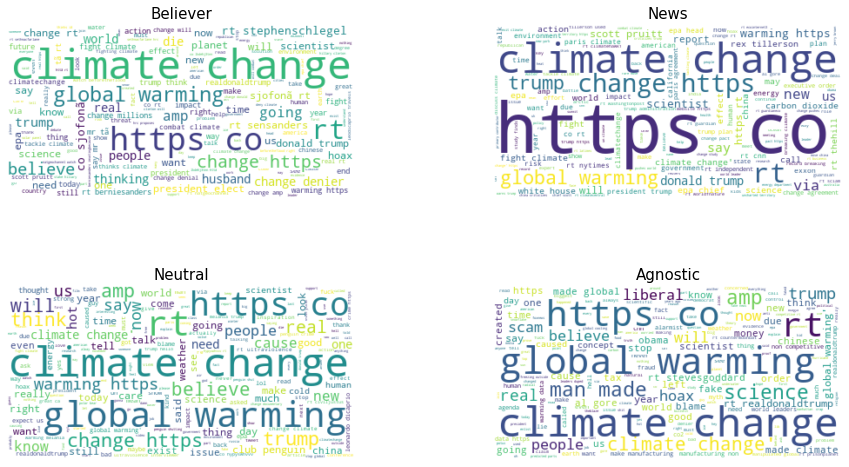

In [11]:
word_cloud(train,raw_corpus)

# **Hashtag analysis**

In this section we look at the hashtags association between the classes, a word count is perfomed and the data visalized in the form of a wordcloud.

In [12]:
def hashtags(input_df,Corpus):
    """Function output the wordcloud of a class given
       a dataframe with a sentiment column and a corpus"""
    df = input_df.copy()
    fig, axs = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(hspace = 0.5, wspace=.2)
    axs = axs.ravel()
    for index, stance in enumerate(df.sentiment.unique()):
        corpus = list(np.array(Corpus)[df[df.sentiment == stance].index.values])
        for line in range(len(corpus)):
            corpus[line] = ' '.join([word for word in corpus[line].split() if word.startswith('#')])
        corpus = ' '.join([word for word in corpus if word])
        corpus = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", corpus)
        word_cloud = WordCloud(background_color='black', max_font_size=80).generate(corpus)
        axs[index].set_title(f'{stance}',fontsize=15)
        axs[index].imshow(word_cloud,interpolation='bilinear')
        axs[index].axis('off')

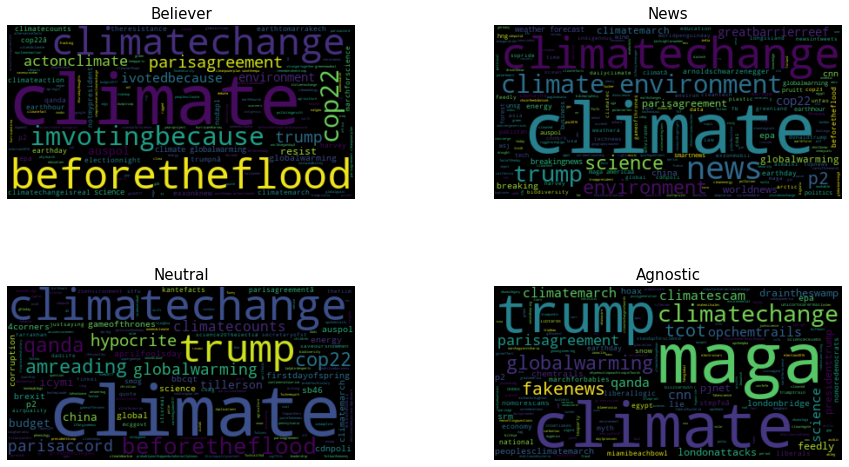

In [13]:
hashtags(train,raw_corpus)

# **Green Speak Terms**

In [14]:
green_terms = ['biofuels','photovoltaic',
               'cap-and-trade','pollution',
               'carbon dioxide','renewable energy',
               'carbon footprint','solar',
               'carbon offsets','wind energy',
               'carbon tax','carcinogen',
               'clean energy','clean tech', 
               'climate bill','climate change',
               'corporate social responsibility',
               'cradle to cradle','ecolabel',
               'energy','fossil fuels',
               'green economy','green roof',
               'green-collar','greenhouse',
               'cycle assessment','wind power','green',
               'carbon','dioxide']
def green_speak(input_df,Corpus):
    """Function output the wordcloud of a class given
       a dataframe with a sentiment column and a corpus"""
    df = input_df.copy()
    fig, axs = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(hspace = 0.5, wspace=.2)
    axs = axs.ravel()
    for index, stance in enumerate(df.sentiment.unique()):
        corpus = np.array(Corpus)[df[df.sentiment == stance].index.values]
        corpus = ' '.join(corpus)
        corpus = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", corpus)
        word_dict = {}
        for term in green_terms:
            if term in corpus:
                word_dict[term] = corpus.count(term)
        word_cloud = WordCloud(background_color='black', max_font_size=80).generate_from_frequencies(word_dict)
        axs[index].set_title(f'{stance}',fontsize=15)
        axs[index].imshow(word_cloud,interpolation='bilinear')
        axs[index].axis('off')

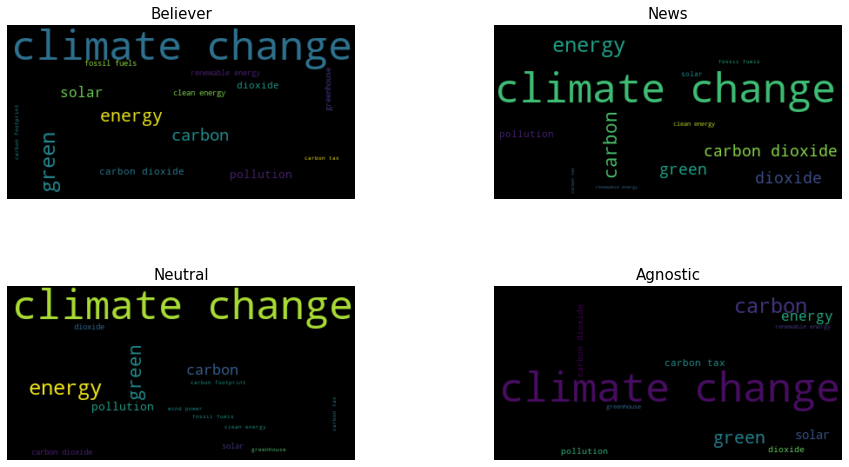

In [15]:
green_speak(train,raw_corpus)

# **Class Imbalance**

This section aims to look at class imbalance of the given dataset

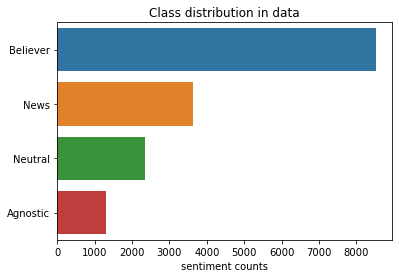

In [16]:
imbalance = sns.barplot(x = train.sentiment.value_counts(), y= train.sentiment.value_counts().index)
imbalance.set(title = 'Class distribution in data',xlabel='sentiment counts')
plt.show()

The data shows imbalanced data with 59% of the sample being in the Believer class and only 8% being in the Agnostics class, this may lead to a biased model. This hypothesis was tested by oversampling the minority classes to half the number of the Believers class and further undersampling the believers class to half its size in the train set, the results yeilded a decrease in model perfomance.

# **Tweet length distribution** 

In [17]:
def boxplot(input_df):
    df = input_df.copy()
    df.tweet_length = df.message.apply(lambda x: len(x))
    plot = sns.boxplot(x=df.tweet_length,y=df.sentiment)
    plot.set(xlabel='tweet_lenght')
    return(plot)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


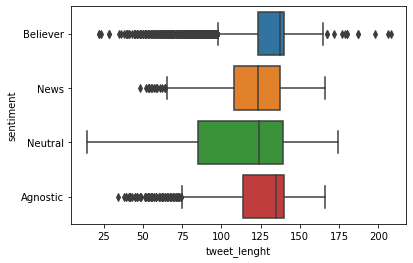

In [18]:
boxplot(train)
plt.show()

The plot indicates that news and neutral tweeps tend to write shorter messages as compared to the agnostics and believers, neutral tweets have a higher variation (with some being very short and others very long), it is also quite possibly harder to extract sentiment from shorter tweets as they do not give enough context.

# **Data Preprocessing** 

This section aims to clean the raw data into the most important text articles, after cleaning the raw data a visualization similar to the one on the EDA step is shown. The data is cleaned using the cleaning_fun function which applies the use of regular expressions, list comprehensions and nltk packages (tokenization and stop words) to remove text which is deemed non-significant for sentiment analysis.

In [19]:
# Set stopwords
added_stop_words = ['rt','dm']
stop_words = set(stopwords.words("english")+added_stop_words)
removed_stop_words = ['not','do']
for i in removed_stop_words:
    stop_words.remove(i)

In [20]:
# Define Cleanig function
def cleaning_fun(tweet):
    """This function takes a tweet and extracts important text"""
    tweet = tweet.lower()
    tweet = re.sub(r'https?://\S+|www\.\S+','',tweet) # Remove URLs
    tweet = re.sub(r'<.*?>','',tweet) # Remove html tags
    tweet = re.sub(r'abc|cnn|fox|sabc','news',tweet) # Replace tags with news
    tweet = re.sub(r'climatechange','climate change',tweet)
#   Tokenize tweet
    tokenizer = TreebankWordTokenizer()
    tweet = tokenizer.tokenize(tweet)
    tweet = [word for word in tweet if word.isalnum()] #Remove punctuations
#   Remove numbers
    tweet = [word for word in tweet if not any(c.isdigit() for c in word)]
#   Replace News if news is in the words
    tweet = ['news' if 'news' in word else word for word in tweet]
#   Replace word with trump if trump is in the word
    tweet = ['trump' if 'trump' in word else word for word in tweet]
#   Remove stop words
    tweet = ' '.join([word for word in tweet if word not in stop_words])
    return(tweet)

In [21]:
# Add clean tweets column to train data
train['clean_tweets'] = train.message.apply(lambda x: cleaning_fun(x))
train.head(3)

,sentiment,message,tweetid,clean_tweets
0,Believer,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...
1,Believer,It's not like we lack evidence of anthropogeni...,126103,not like lack evidence anthropogenic global wa...
2,News,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...


In [22]:
# cleaned corpus
clean_corpus = [cleaning_fun(tweet) for tweet in raw_corpus]

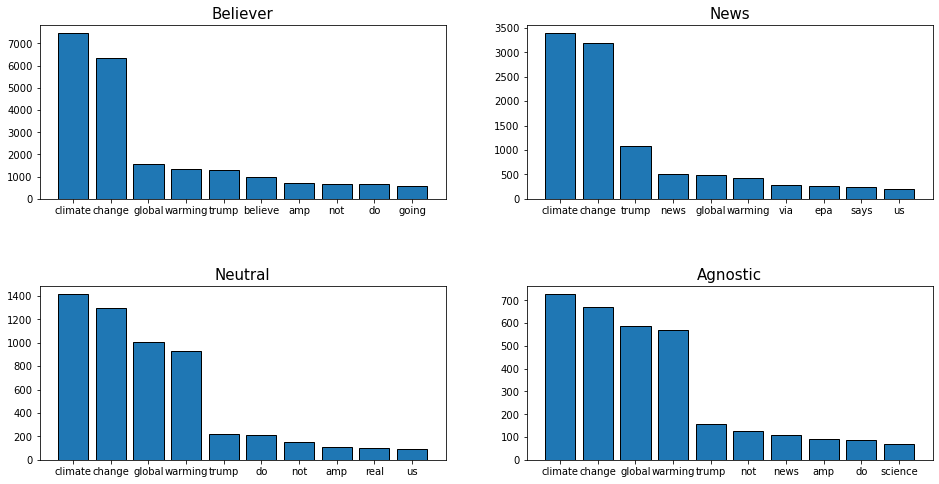

In [23]:
word_count(train,clean_corpus)

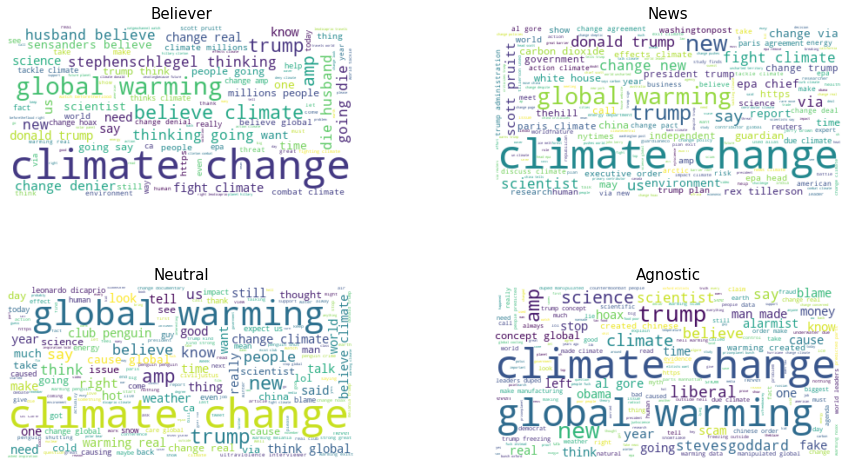

In [24]:
word_cloud(train,clean_corpus)

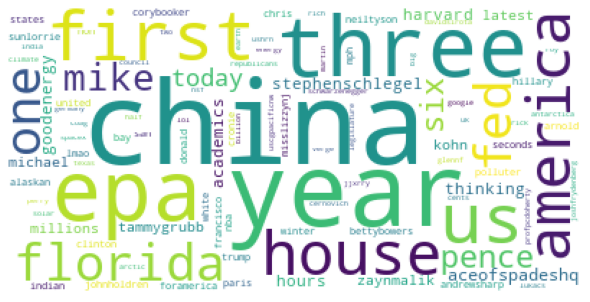

In [25]:
def NER(corpus):
    nlp = spacy.load('en_core_web_sm')
    seperator=','
    y=[]
    doc=nlp(seperator.join(clean_corpus[:90]))
    for entity in doc.ents:
        y.append(entity.text)
    word_cloud = WordCloud(background_color='white', max_font_size=80).generate(seperator.join(y))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(word_cloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
NER(clean_corpus)

In [26]:
data = pd.read_csv('../input/mbti-type/mbti_1.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../input/mbti-type/mbti_1.csv'

In [27]:
def MBTI(input_df,train):
    df = input_df.copy()
    for i in range(len(df)):
        df.posts[i] = BeautifulSoup(df.posts[i], "lxml").text
        df.posts[i] = re.sub(r'\|\|\|', r' ', df.posts[i])
        df.posts[i] = re.sub(r'http\S+', r'<URL>', df.posts[i])
    np.random.seed(1)
    tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english',lowercase = True, max_features = 5000)
    model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005,max_iter=300))])
    warnings.filterwarnings("ignore")
    model_lr.fit(df.posts, df.type)
    separator = ', '
    a=separator.join(train.query("sentiment=='News'")['clean_tweets'][:1000].values.tolist())
    b=separator.join(train.query("sentiment=='Believer'")['clean_tweets'][:1000].values.tolist())
    c=separator.join(train.query("sentiment=='Neutral'")['clean_tweets'][:1000].values.tolist())
    d=separator.join(train.query("sentiment=='Agnostic'")['clean_tweets'][:1000].values.tolist())
    k=[a,b,c,d]
    pred_all = model_lr.predict(k)
    return (pred_all)
MBTI(data,train)

NameError: name 'data' is not defined

# **Vectorize Corpus and Split Data** 

In [28]:
#instantiate and vectorize corpus
count_vectorizer = CountVectorizer(ngram_range=(1,2))
count_vectorizer.fit(clean_corpus)

CountVectorizer(ngram_range=(1, 2))

In [29]:
#Included for pickling to web app (not used in actual model) 
tfvectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tfvectorizer.fit(clean_corpus)

TfidfVectorizer(min_df=0.0, ngram_range=(1, 2), sublinear_tf=True)

In [30]:
# Define feature and target variables
X = train.message
y = train.sentiment

In [31]:
# Tran test split data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [32]:
# Vectorize test and train set
X_train = count_vectorizer.transform(X_train)
X_test = count_vectorizer.transform(X_test)

In [33]:
# Define Classification Models to be tested with default parameters
models = {'LogisticReg': LogisticRegression(multi_class='ovr',
                                            class_weight='balanced',
                                            max_iter=1000),
          'LinearSVC': LinearSVC(),
          'RandomForest': RandomForestClassifier(n_estimators=5)}

In [34]:
perfomance_df = pd.DataFrame()
for name in models.keys():
    scores = cross_val_score(models[name], X_train, y_train, cv=5, scoring='f1_weighted')
    mean_score = round(scores.mean(),2)
    mean_stddev = round(scores.std(),3)
    temp = pd.DataFrame({'weighted_f1_avg':mean_score,'deviation':mean_stddev}, index=[name])
    perfomance_df = pd.concat([perfomance_df, temp])
print(perfomance_df.sort_values('weighted_f1_avg', ascending=False))

              weighted_f1_avg  deviation
LogisticReg              0.73      0.004
LinearSVC                0.72      0.003
RandomForest             0.64      0.007


In [35]:
# Validation of Models
val_df = pd.DataFrame()
for name in models.keys():
    models[name].fit(X_train,y_train)
    y_pred = models[name].predict(X_test)
    eval_score = f1_score(y_test,y_pred,average='weighted')
    eval_score = round(eval_score,2)
    temp = pd.DataFrame({'weighted_f1_avg':eval_score}, index=[name])
    val_df = pd.concat([val_df, temp])
print(val_df.sort_values('weighted_f1_avg', ascending=False))

              weighted_f1_avg
LogisticReg              0.75
LinearSVC                0.73
RandomForest             0.66


In [36]:
chosen_model = 'LogisticReg'

In [37]:
y_pred = models[chosen_model].predict(X_test)

In [38]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,5)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

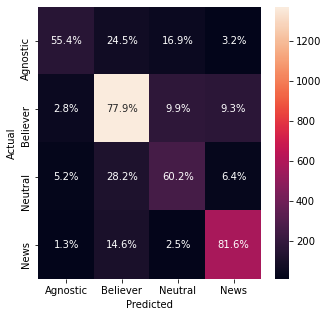

In [39]:
cm_analysis(y_test,y_pred,models[chosen_model].classes_)

In [40]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n    Agnostic       0.66      0.55      0.60       278\n    Believer       0.82      0.78      0.80      1755\n     Neutral       0.52      0.60      0.56       425\n        News       0.74      0.82      0.78       706\n\n    accuracy                           0.74      3164\n   macro avg       0.69      0.69      0.68      3164\nweighted avg       0.75      0.74      0.75      3164\n'

In [41]:
parameters = {'C':[10,5,1],
              'multi_class': ['ovr','multinomial']}
grid_search = GridSearchCV(models[chosen_model], parameters,scoring='f1_weighted')
grid_search.fit(X_train, y_train)
search_params = grid_search.best_params_

In [42]:
best_logistic_model = LogisticRegression(multi_class=search_params['multi_class'],
                                         class_weight='balanced',
                                         max_iter=1000,
                                         C = search_params['C'])
score = cross_val_score(best_logistic_model, X_train, y_train, cv=5, scoring='f1_weighted')
mean_score = round(score.mean(),2)
print(mean_score)

0.73


# **Model Metrics on test data**

In [43]:
best_logistic_model.fit(X_train,y_train)
y_pred = best_logistic_model.predict(X_test)

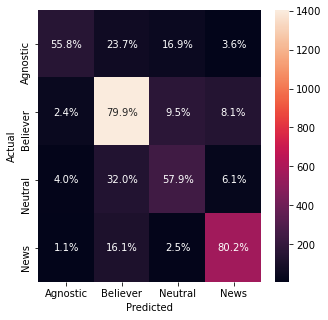

In [44]:
# Confussion Matrix
cm_analysis(y_test,y_pred,best_logistic_model.classes_)

In [45]:
#classifiaction report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Agnostic       0.70      0.56      0.62       278
    Believer       0.82      0.80      0.81      1755
     Neutral       0.51      0.58      0.54       425
        News       0.76      0.80      0.78       706

    accuracy                           0.75      3164
   macro avg       0.70      0.68      0.69      3164
weighted avg       0.75      0.75      0.75      3164



# **Submission File Preparation**

In [46]:
# Clean test file
test.message = test.message.apply(lambda x: cleaning_fun(x))

In [47]:
test_X = count_vectorizer.transform(test.message)

In [48]:
test_pred = best_logistic_model.predict(test_X)

In [49]:
output = pd.DataFrame({'tweetid':test.tweetid,'sentiment':test_pred})
# Replace original labels
new_dict = {'Agnostic':-1,'Neutral':0,'Believer':1,'News':2}
output.replace({'sentiment':new_dict},inplace=True)

In [50]:
output.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [51]:
output.to_csv('my_submission.csv', index=False)